In [1]:
import os

import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras


## image, label 설정
img_path = 'D:/cube_resized/86/'
lbl_path = 'D:/cube_labels/86/'

str_path = next(os.walk(img_path))[1]

cnt = 0
files = []
for i in str_path:
    for j in next(os.walk(lbl_path + i))[2]:
        files.append(i + '/' + j[1:])
        cnt += 1

low_image = np.zeros((cnt,256,256,3))
low_label = np.zeros((cnt,256,256))

for n, strength in enumerate(str_path):
    image_paths = img_path + strength + '/'
    label_paths = lbl_path + strength + '/'
    ep = len(next(os.walk(label_paths))[2])
    for i, lbl in enumerate(next(os.walk(label_paths))[2]):
        
        img = lbl[1:]
        
        image = plt.imread(image_paths + img)
        low_image[n*ep + i] = image[:,:,:3]
        
        label = plt.imread(label_paths + lbl)
        if label.ndim == 3:
            low_label[n*ep + i] = label[:,:,:1].reshape(256,256)
        else:
            low_label[n*ep + i] = label
            
            
# ## 시각화
# plt.figure(figsize=(15,15))
# plt.subplot(2,2,1)
# plt.imshow(low_image[5])
# plt.subplot(2,2,2)
# plt.imshow(low_label[5])
# plt.subplot(2,2,3)
# plt.imshow(low_image[15])
# plt.subplot(2,2,4)
# plt.imshow(low_label[15])


# Kfold
from sklearn.model_selection import KFold

df = pd.DataFrame({'file_name':files,'fold':[-1 for i in range(len(low_image))]})

kf = KFold(n_splits=5, shuffle=True, random_state=32)

for idx, (t,v) in enumerate(kf.split(low_image)):
    df.loc[v, 'fold'] = idx


# Augmentation
import albumentations as A

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=45,
                ),
                A.RandomRotate90(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            mask = augmented['mask']
            return img, mask
        
        
# Generator
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, df, image, label,
                fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.image = image
        self.label = label
        
        self.df = df
        
        # train : 해당 fold에 해당하는 데이터를 제외하고 가져옴
        # val : 해당 fold에 해당하는 데이터를 가져옴
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        
        # Data Augmentation
        self.transform = Augmentation(image_size, mode)
        
        # 학습을 시작할 때도(첫 epoch) 셔플해주려면,
        self.on_epoch_end()
        
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
        
    def __getitem__(self, idx):
        
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.image, self.label
        
        return np.array(batch_x), np.array(batch_y)
        
    
    def on_epoch_end(self):
        
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

train_generator = DataGenerator(
    batch_size=8,
    df=df,
    image=low_image,
    label=low_label,
    fold=1,
    image_size=256,
    mode='train',
    shuffle=True)

valid_generator = DataGenerator(
    batch_size=8,
    df=df,
    image=low_image,
    label=low_label,
    fold=1,
    image_size=256,
    mode='val',
    shuffle=True)


# Loss
import tensorflow.keras.losses as losses

def iou(y_true, y_pred):
    
    smooth = 1.  # 0으로 나누는 것 방지
    
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    score = intersection / (union + smooth)
    return score

def dice_coef(y_true, y_pred):
    
    smooth = 1.  # 0으로 나누는 것 방지
    
    # Flatten
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    
    intersection = tf.reduce_sum(y_true * y_pred)
    
    score = (2 * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
    return score

def dice_loss(y_true, y_pred):
    
    loss = 1 - dice_coef(y_true, y_pred)

    return loss

def bce_dice_loss(y_true, y_pred):
    
    loss = 1. * losses.binary_crossentropy(y_true,y_pred) + 1. * dice_loss(y_true, y_pred)

    return loss

In [5]:
# # model compile
# from keras_unet.models import custom_unet

# model = custom_unet(
#     input_shape=(256, 256, 3),
#     use_batch_norm=True,  # True로 해주는게 좋음
#     upsample_mode='deconv',  # deconv가 일반적
#     use_attention=True,  # hyperparameter로 비교하지만, 사용하는게 좋음
#     filters=16,
#     num_layers=2 ,  # conv layer갯수로 얼마나 깊은지 hyperparameter
#     num_classes=1,
#     dropout_type='spatial',  # hyperparameter의 의미로 'standard'와 비교해서 쓰지만, 일반적으로 spatial로 하는게 성능이 좋다고 알려짐
#     dropout=0.2,
#     output_activation='sigmoid')

# model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy', iou])
# model.summary()

# # 학습
# history = model.fit(
#     train_generator,
#     validation_data=valid_generator,
#     epochs=100,
#     verbose=1)

In [2]:
from tensorflow.keras.models import load_model
model = load_model('first_model.h5', custom_objects={'bce_dice_loss':bce_dice_loss, 'iou':iou})

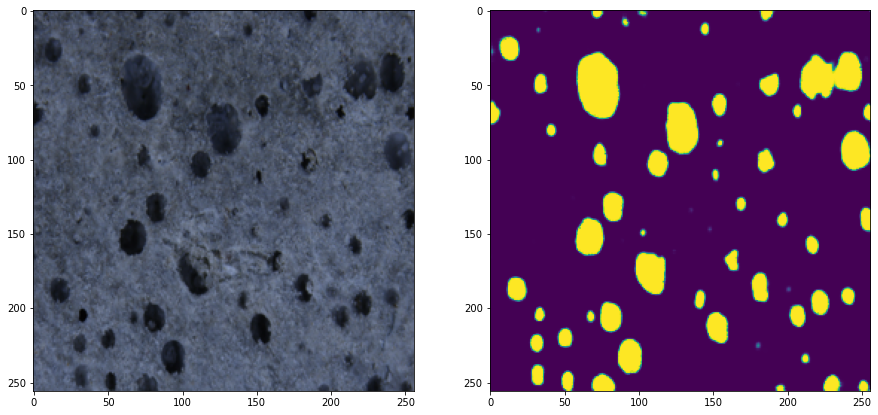

In [3]:
test_image_path = 'D:/cube_resized/86/24/0030.png'
test_image = plt.imread(test_image_path)

tests = np.zeros((1,256,256,3))
tests[0] = test_image[:,:,:3]
tests[0]

preds = model.predict(tests).reshape(256,256)


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(test_image)
plt.subplot(1,2,2)
plt.imshow(preds)

In [4]:
import numpy as np

def Predict_model(images):
    
    image_datas = np.zeros((len(images), 256,256,3))
    
    for i in range(len(images)):
        image_datas[i] = images[i][:,:,:3]
        
    preds = model.predict(image_datas)
    
    for i in range(len(images)):
        preds[i] = preds[i]
        
    return preds

In [31]:
## image, label 설정
test_img_path = 'D:/cube_resized/86/24/'

num = 50

test_images = np.zeros((num,256,256,3))

for i in range(num):
    test_images[i] = plt.imread(test_img_path + next(os.walk(test_img_path))[2][i+50])[:,:,:3]



# for i, lbl in enumerate(next(os.walk(test))[2]):

#     img = lbl[1:]

#     image = plt.imread(image_paths + img)
#     low_image[n*ep + i] = image[:,:,:3]

#     label = plt.imread(label_paths + lbl)
#     if label.ndim == 3:
#         low_label[n*ep + i] = label[:,:,:1].reshape(256,256)
#     else:
#         low_label[n*ep + i] = label

In [32]:
test_labels = Predict_model(test_images)

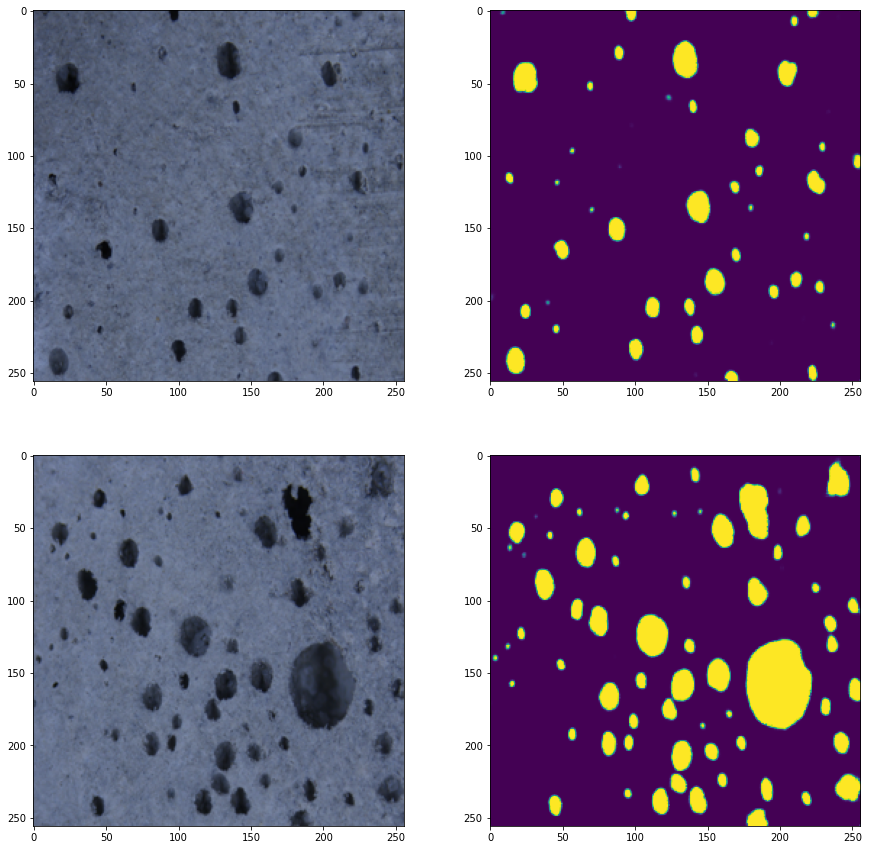

In [33]:
## 시각화
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(test_images[14])
plt.subplot(2,2,2)
plt.imshow(test_labels[14])
plt.subplot(2,2,3)
plt.imshow(test_images[6])
plt.subplot(2,2,4)
plt.imshow(test_labels[6])

In [34]:
porosity_24 = []
for i in range(test_labels.shape[0]):
    cnt = 0
    for j in range(256):
        for k in range(256):
            if test_labels[i][j][k] >= 0.5:
                cnt += 1
    porosity_24.append(cnt/(256*256)*100)
    
porosity_24

[4.0802001953125,
 5.20782470703125,
 10.63232421875,
 5.00335693359375,
 6.16912841796875,
 6.03790283203125,
 13.720703125,
 10.986328125,
 4.9468994140625,
 6.097412109375,
 7.244873046875,
 12.34588623046875,
 14.26849365234375,
 7.38067626953125,
 4.82330322265625,
 5.615234375,
 5.7281494140625,
 7.623291015625,
 13.519287109375,
 9.4512939453125,
 12.18414306640625,
 13.30718994140625,
 13.46282958984375,
 11.56158447265625,
 22.6104736328125,
 9.45281982421875,
 7.02667236328125,
 11.7279052734375,
 8.9385986328125,
 6.63604736328125,
 6.51092529296875,
 11.53411865234375,
 12.933349609375,
 3.472900390625,
 6.79931640625,
 3.98406982421875,
 10.16693115234375,
 6.37969970703125,
 11.60736083984375,
 9.8175048828125,
 12.07122802734375,
 6.84051513671875,
 7.64312744140625,
 11.75689697265625,
 12.1917724609375,
 5.8380126953125,
 8.6273193359375,
 6.04705810546875,
 6.89239501953125,
 7.5164794921875]

In [35]:
np.average(porosity_24)

8.928436279296875

In [36]:
test_img_path = 'D:/cube_resized/86/35/'

num = 50
test_images = np.zeros((num,256,256,3))

for i in range(num):
    test_images[i] = plt.imread(test_img_path + next(os.walk(test_img_path))[2][i+50])[:,:,:3]

    
    
test_labels = Predict_model(test_images)

In [37]:
porosity_35 = []
for i in range(test_labels.shape[0]):
    cnt = 0
    for j in range(256):
        for k in range(256):
            if test_labels[i][j][k] >= 0.5:
                cnt += 1
    porosity_35.append(cnt/(256*256)*100)
    
porosity_35

[3.1646728515625,
 2.6123046875,
 1.1566162109375,
 5.04608154296875,
 2.20947265625,
 1.23443603515625,
 7.879638671875,
 1.226806640625,
 1.165771484375,
 1.55487060546875,
 1.6632080078125,
 2.10723876953125,
 2.2308349609375,
 18.609619140625,
 5.694580078125,
 2.46124267578125,
 3.64837646484375,
 2.04010009765625,
 1.97601318359375,
 1.8096923828125,
 3.0975341796875,
 2.0233154296875,
 5.908203125,
 4.90570068359375,
 4.046630859375,
 3.75518798828125,
 5.57403564453125,
 5.4290771484375,
 4.8187255859375,
 3.93829345703125,
 1.03759765625,
 4.13055419921875,
 1.9195556640625,
 1.38702392578125,
 2.78778076171875,
 4.79888916015625,
 2.64739990234375,
 0.8087158203125,
 3.3477783203125,
 3.2928466796875,
 2.4993896484375,
 1.93939208984375,
 0.60882568359375,
 3.69110107421875,
 7.64923095703125,
 2.79998779296875,
 2.09503173828125,
 3.50341796875,
 0.84228515625,
 0.74615478515625]

In [38]:
np.average(porosity_35)

3.3104248046875

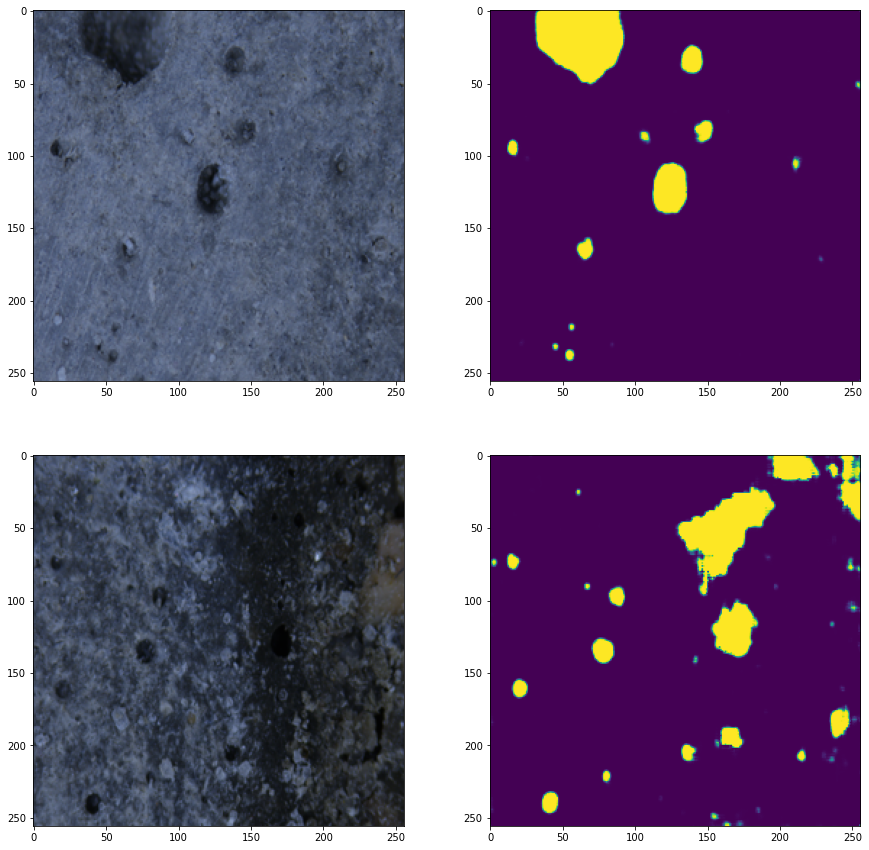

In [39]:
## 시각화
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(test_images[14])
plt.subplot(2,2,2)
plt.imshow(test_labels[14])
plt.subplot(2,2,3)
plt.imshow(test_images[6])
plt.subplot(2,2,4)
plt.imshow(test_labels[6])

In [40]:
test_img_path = 'D:/cube_resized/86/50/'

num = 50
test_images = np.zeros((num,256,256,3))

for i in range(num):
    test_images[i] = plt.imread(test_img_path + next(os.walk(test_img_path))[2][i+50])[:,:,:3]

    
    
test_labels = Predict_model(test_images)

In [41]:
porosity_50 = []
for i in range(test_labels.shape[0]):
    cnt = 0
    for j in range(256):
        for k in range(256):
            if test_labels[i][j][k] >= 0.5:
                cnt += 1
    porosity_50.append(cnt/(256*256)*100)
    
porosity_50

[0.457763671875,
 0.35400390625,
 0.84381103515625,
 0.9033203125,
 1.52587890625,
 1.23138427734375,
 0.35858154296875,
 0.177001953125,
 0.335693359375,
 0.83465576171875,
 3.582763671875,
 0.946044921875,
 0.71868896484375,
 2.71453857421875,
 0.25787353515625,
 0.994873046875,
 0.54473876953125,
 2.2064208984375,
 0.07781982421875,
 1.678466796875,
 1.025390625,
 1.71966552734375,
 0.0579833984375,
 1.12457275390625,
 2.6336669921875,
 1.3580322265625,
 0.82244873046875,
 0.88043212890625,
 0.5340576171875,
 0.37689208984375,
 1.5472412109375,
 0.46539306640625,
 0.23040771484375,
 0.6744384765625,
 0.07781982421875,
 0.76751708984375,
 6.25,
 3.95965576171875,
 1.49688720703125,
 0.63629150390625,
 0.15869140625,
 1.763916015625,
 0.3875732421875,
 0.6072998046875,
 21.50421142578125,
 1.66168212890625,
 2.82135009765625,
 2.68096923828125,
 1.0345458984375,
 0.37841796875]

In [42]:
np.average(porosity_50)

1.607635498046875

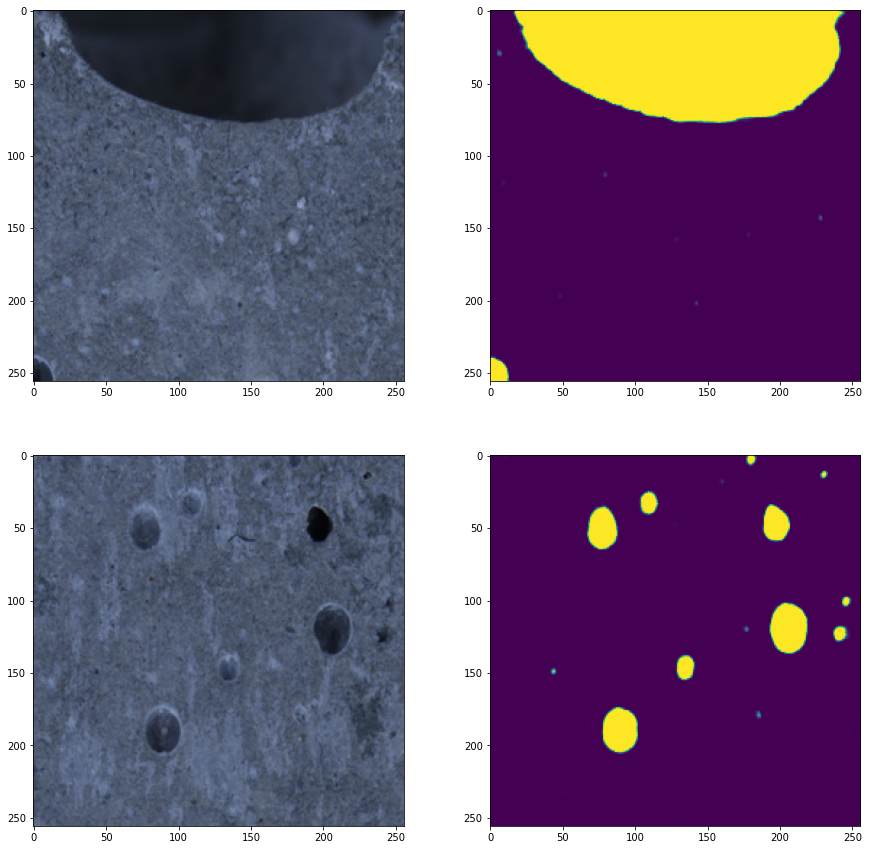

In [43]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.imshow(test_images[44])
plt.subplot(2,2,2)
plt.imshow(test_labels[44])
plt.subplot(2,2,3)
plt.imshow(test_images[37])
plt.subplot(2,2,4)
plt.imshow(test_labels[37])

Text(0.5, 1.0, 'Test')

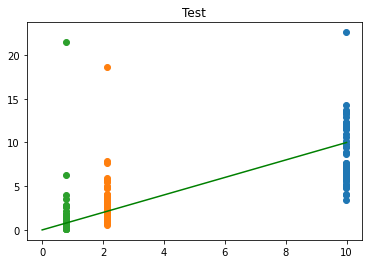

In [45]:
plt.scatter([9.97 for i in range(num)],porosity_24)
plt.scatter([2.13 for i in range(num)],porosity_35)
plt.scatter([0.77 for i in range(num)],porosity_50)

# y=x 직선 그리기
t = np.arange(0,11)
plt.plot(t,t,'g-')
plt.title('Test')